In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np

dl = DataLoader("/home/panda/rf_data/")

picmus_names = [
    "contrast_speckle_expe_dataset_rf",
    "contrast_speckle_simu_dataset_rf",
    "resolution_distorsion_expe_dataset_rf",
    "resolution_distorsion_simu_dataset_rf",
    "carotid_cross_expe_dataset_rf",
    "carotid_long_expe_dataset_rf"
]

#picmus_names = [ "contrast_speckle_expe_dataset_rf" ]
#picmus_names = [ "carotid_cross_expe_dataset_rf" ]
picmus_names = [ "JHU028" ]
#picmus_names = [ "INS018" ]
#picmus_names = [ "TSH002" ]


#picmus_names = [ "INS023", "INS018", "MYO001", "MYO003"]


nz = 2048
nx = 256

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

bf_names = ["MVB"]
#bf_names = ["DASGridSample"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    #angles_idx = np.array([32])

    f_num = 1.75
    window = "tukey25"

    with torch.profiler.profile(
        activities=[
            ProfilerActivity.CPU,
            ProfilerActivity.CUDA,
        ],
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        with_flops=False, 
    ) as prof:
        bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
        output[name] = bw.compute_reconstructions()
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=-1))


contrast_speckle_expe_dataset_rf
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               aten::linalg_cholesky_ex         0.13%      10.621ms         0.44%      37.014ms     123.381us        1.675s        20.72%        2.363s       7.876ms           0 B        

In [4]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

#bf_names = ["MVB"]
#bf_names = ["DASGridSample"]
bf_names = ["DASManual"]


output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    #print(pw)
    #pw.c0 = 1463
    #angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    angles_idx = np.array([pw.n_angles//2])

    f_num = 1.75
    window = "tukey25"

    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
    output[name] = bw.compute_reconstructions()

JHU028


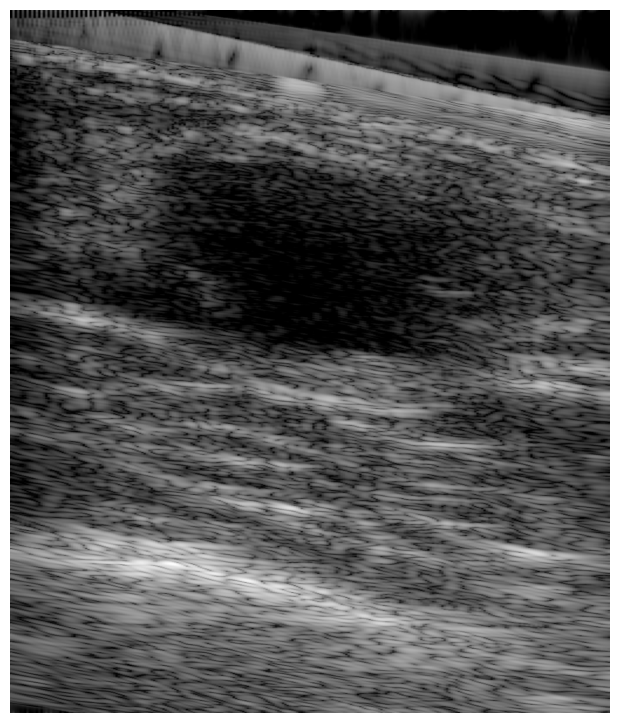

In [5]:
import matplotlib.pyplot as plt

#TODO: Revisar el data_loader y tratar de que sea igual al original de Hyun para verificar y que las imagenes sean las mismas
# que en el paper relacionado.

picmus_idx = 0
bf_idx = 0
o = output[picmus_names[picmus_idx]][bf_names[bf_idx]]

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=vmin, vmax=vmax)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()